In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install -U tensorflow-text==2.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 7.3 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 20.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 27.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 24.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninst

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as tf_text
import matplotlib.pyplot as plt

In [4]:
print(tf.__version__)

2.6.4


In [27]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',trainable=True)

2022-08-30 07:40:57.504594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 07:40:57.671016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 07:40:57.676348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 07:40:57.682173: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

2022-08-30 07:41:18.632301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [10]:
def get_embedding(text):
    preprocessed_text = bert_preprocess(text)
    return bert_encoder(preprocessed_text)['pooled_output']

# **Build Model**

In [11]:
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
encoded_text = bert_encoder(preprocessed_text)

x = tf.keras.layers.Dropout(0.2)(encoded_text['pooled_output'])
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

In [12]:
model = tf.keras.Model(inputs=[text_input],outputs=[output])
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("embedding_bert.keras", save_best_only=True,monitor='val_loss')]

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'input_type_ids': ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'encoder_outputs':  109482241   keras_layer_1[0][0]              
                                                                 keras_layer_1[0][1]              
                                                                 keras_layer_1[0][2]              
______________________________________________________________________________________________

In [15]:
history = model.fit(train['text'],train['target'],epochs=5,validation_split=0.2,callbacks=callbacks)

Epoch 1/5
191/191 [==============================] - 143s 656ms/step - loss: 0.4730 - accuracy: 0.7788 - val_loss: 0.3814 - val_accuracy: 0.8391
Epoch 2/5
191/191 [==============================] - 123s 643ms/step - loss: 0.3542 - accuracy: 0.8578 - val_loss: 0.3616 - val_accuracy: 0.8398
Epoch 3/5
191/191 [==============================] - 122s 638ms/step - loss: 0.2956 - accuracy: 0.8860 - val_loss: 0.3711 - val_accuracy: 0.8496
Epoch 4/5
191/191 [==============================] - 122s 639ms/step - loss: 0.2329 - accuracy: 0.9146 - val_loss: 0.4048 - val_accuracy: 0.8411
Epoch 5/5
191/191 [==============================] - 123s 644ms/step - loss: 0.1755 - accuracy: 0.9374 - val_loss: 0.5046 - val_accuracy: 0.8313


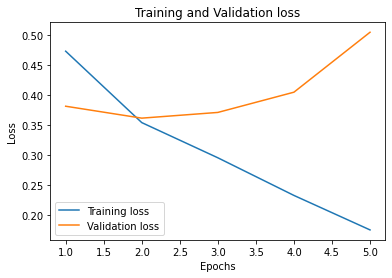

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 6)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

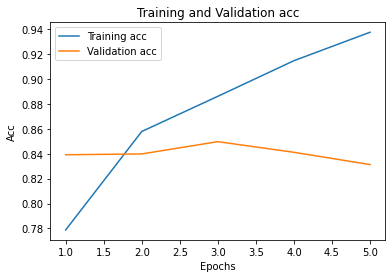

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, 6)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [19]:
y_pred = model.predict(test['text'])

In [20]:
y_pred

array([[0.99604553],
       [0.99803287],
       [0.99784636],
       ...,
       [0.9988154 ],
       [0.9661214 ],
       [0.99596655]], dtype=float32)

In [29]:
submission['target'] = y_pred.round().astype('int')

In [33]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [34]:
submission.to_csv('submission.csv', index=False)

Score was 0.80753